This notebook is  a follow up of the lab session on Fashion MNIST. Be sure you did and understood the previous notebook on applying the feed-forward neural network with pytorch.

The goal is to incrementally build an image classifier based on convolutional layers. Since we consider images and convolution we will use Tensors with peculiar shapes in input. Moreover, this session is also the occasion to introduce "Max-pooling" and "Batch-normalization". 




# Dataset

First the dataset !  The provided version is unfortunately not adapted to our purpose in terms of dimensions. 
*Convolution2D* expects as input a Tensor with 4 dimensions $(N,C,H,W)$ with : 

- N the batch dimension, *i.e* the number of images
- C the number of input channels, here it is 1
- H the height or number of rows of each image
- W the width  or number of columns of each image


In [2]:
# math, numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt 
# torch 
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
# gzip 
import gzip
import pickle

# Load the dataset
fp = gzip.open('fashion-mnist.pk.gz','rb')
allXtrain, allYtrain, Xvalid, Yvalid, classlist  = pickle.load(fp) 


## Select data

Write the code to get two variables: Xtrain which contains N training images, and Ytrain the associates labels. 
- Set N to 20000 to start. 
- The shape of Xtrain should follow the guidelines for convolutions. 


In [43]:
# TODO
N=20000
C = 1
H = 28
W = 28

Xtrain = allXtrain[:N].view(N,C,H,W)
Ytrain = allYtrain[:N]

Xvalid = Xvalid.view(-1,C,H,W)

print(Xtrain.shape)


torch.Size([20000, 1, 28, 28])


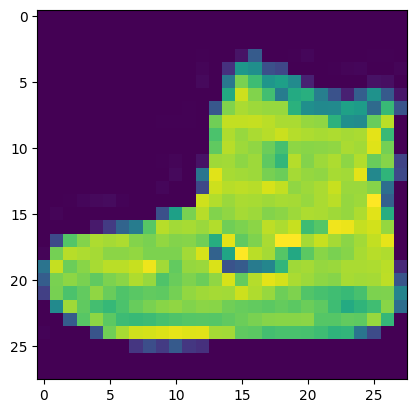

In [44]:
plt.imshow(Xtrain[0].squeeze().detach().numpy())

# Training wrapper

Before playing with convolution, you can reuse the training function you wrote carefully in the previous lab session. 

In [45]:
# TODO : paste here the training function you wrote before.
# Of course you can improve it if you want during the lab session.
# Especially in terms of parameters. 

def train(model, epochs=10,verbose=False):
    loss_fn=nn.NLLLoss()
    ### Mini-batching and shuffle 
    Ntrain = Xtrain.shape[0] 
    Nvalid = Xvalid.shape[0]
    print(Ntrain,Nvalid)
    idx = np.arange(Ntrain) # Generate the indices 
    batch_size =100
    nbatch = int(Ntrain/batch_size) # the number of batches
    print(batch_size, nbatch)

    np.random.shuffle(idx) # random order of indices 
    bi = 2 # a random choice
    ids = idx[bi*batch_size:(bi+1)*batch_size] # Get indices
    images = Xtrain[ids]  # Get the images
    labels = Ytrain[ids]  # The Labels

    for i in range(epochs):
        np.random.shuffle(idx) # random order of indices 
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size] # Get indices
            images = Xtrain[ids]  # Get the images
            labels = Ytrain[ids]  # The Labels
            optimizer.zero_grad()
        
            logprobs=model(images) # inference 
            loss=loss_fn(logprobs,labels) # compute the loss

            loss.backward() # Back propagation
            optimizer.step() # update the parameters

    logprobs=model(Xtrain) # inference 
    print('Loss for train : ', loss_fn(logprobs,Ytrain))

    logprobsV=model(Xvalid) # inference 
    print('Loss for validation : ', loss_fn(logprobsV,Yvalid))

    class_valid = th.argmax(logprobsV, dim=1)
    print("Validation accuracy : ", th.sum(class_valid==Yvalid)/Nvalid*100)

# Playing with convolution in 2D 

Let start the exploration of convolution.The class we will use is called Conv2d. Read carefully the documentation of this module. Maybe you cannot understand everything, but who really can ? That's why it is useful to first play with the convolution with one image. 

In [46]:
# Extract one image to start. 
im = Xtrain[0:1] # it looks wired but we need to keep the four dimensions. 
print(im.shape)  # Try with Xtrain[0] and see that it is not well suited.  

torch.Size([1, 1, 28, 28])


Now create one convolution layer with 1 input channels, a kernel size of 3, and a stride of 1. 
Try it and look at the output dimension. 


In [57]:
# TODO: 
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3,padding = 1, stride=1)

res=conv(im)
print(res.shape)


torch.Size([1, 1, 28, 28])


The resulting "image" is not of the same dimension, how to obtain an output with the same dimension (same question with a kernel size of 5) ? 

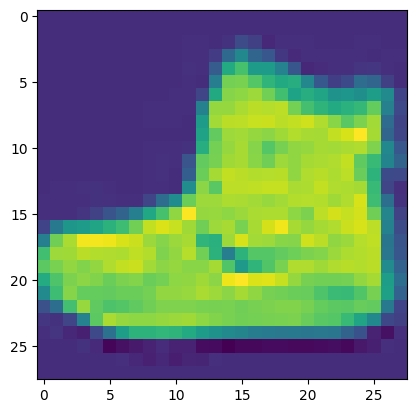

In [58]:
# TODO 

plt.imshow(res[0].squeeze().detach().numpy())

We can define the parameters of the convolutional filter with our own hands. For that purpose we just have to create the Tensor we want and cast it in a *Parameter* object (usefull for autograd) and then assign it. 
This is an example: 

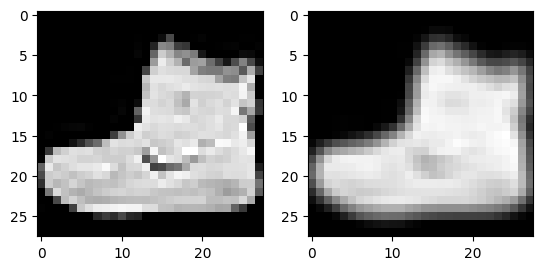

In [49]:
# Create a convolutional filter
convFilter = nn.Conv2d(in_channels=1,out_channels=1,
                       kernel_size = 3, padding=1,
                       stride=1)
# build the weight matrix you want 
W=th.ones(convFilter.weight.shape) 
# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W)

res = convFilter(im)
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

Now try to set the convolution fiter as follows:
$$
\left(
\begin{array}{ccc}
 -1 &2&-1\\
 -1 &2&-1\\
 -1 &2&-1
\end{array}
\right)
$$
and then as follows: 
$$
\left(
\begin{array}{rrr}
 -1 &-1&-1\\
 2 &2&2\\
 -1 &-1&-1
\end{array}
\right)
$$
Try them on some images and visualize the results. 

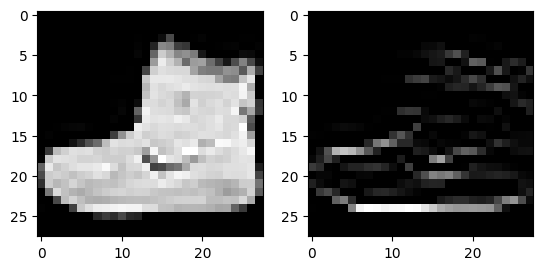

In [62]:
# TODO 
# Create a convolutional filter
convFilter = nn.Conv2d(in_channels=1,out_channels=1,
                       kernel_size = 3, padding=1,
                       stride=1)
# build the weight matrix you want 
#W=th.tensor([[[[-1., 2, -1],[-1, 2, -1],[-1, 2, -1]]]])
#W=th.tensor([[[[1., -2, 1],[1., -2, 1],[1., -2, 1]]]])
W=th.tensor([[[[-1., -1, -1],[2., 2, 2],[-1., -1, -1]]]])
# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W)

res = convFilter(im)
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

# Pool ! 

Now we introduce the max-pooling in 2 dimensions: *MaxPool2d*. Look at the documentation and then try to define the following pipeline: 
- a convolution with a kernel size of 3, stride 1 and padding 1
- apply the ReLu function and
- a max pooling with kernel size of 2 and a stride of 2. 
Try to guess before running your code the dimensions of the output ! 


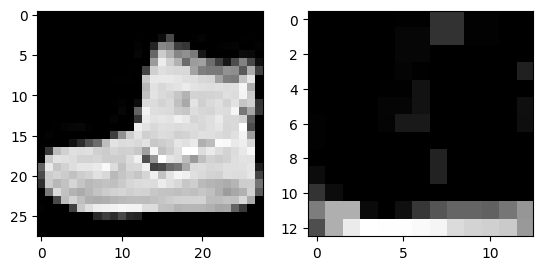

In [63]:
# TODO

model=nn.Sequential(nn.Conv2d(in_channels=1,out_channels=1,
                       kernel_size = 3, padding=1,
                       stride=1),
                  nn.ReLU(),
                    nn.MaxPool2d(kernel_size = 3, stride=2)
                    )


res = model(im)
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

#  A first model

After this interlude, the goal now is to write a class to implement the model with:

- 2D convolution with (kernel size = 3, padding = 1, stride 1)
- ReLu activation 
- Max-pooling (kernel size = 2, stride 2)
- A final linear classifier
- The final activation

Writing this class, allows you to wrap what you have seen so far. To debug the model, you can first play step-by-step with each layer to ensure you obtain the right dimensions (it was done earlier). Then, write the class and run the training to evaluate the result (this what we have to do now).

The class inherits from an existing class of pytorch : *Module*. This mean: it is a *Module*, but we add some peculiarities. For that purpose we can fill the following code: 

In [49]:
# TODO
class FashionCNN(nn.Module):
    
    def __init__(self, kernel_size_Conv2D = 3, padding= 1, out_channels = 16, kernel_size_MaxPool = 2, stride_MaxPool = 2, D_in=14, D_out=10):
        super(FashionCNN, self).__init__()
        # TODO : write the end of the constructor.
        # It is important to create here all the layers of the network. 
        # All layers that have paramaters should be attribute. 
        # For example: 
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, 
                              kernel_size=kernel_size_Conv2D, padding=padding)
        # TODO: add the rest
        self.relu = nn.ReLU()

        self.max = nn.MaxPool2d(kernel_size = kernel_size_MaxPool, stride=stride_MaxPool)

        self.linear = nn.Linear(in_features=D_in*D_in*out_channels,out_features=D_out)

        self.activation = nn.LogSoftmax(dim=1)

        


        
    def forward(self, x):
        # TODO
        # if you need to run forward with the conv layer, 
        # you can call it by self.conv 
        outconv  = self.conv(x)
        outrelu = self.relu(outconv)
        outmax = self.max(outrelu)
        outtrain = self.linear(outmax.view(outmax.size(0),-1))
        output = self.activation(outtrain)
        return output

In [50]:
# Test the class: is everything in place:
# A first classifier is built like : 
classif = FashionCNN()
# The parameters of the classifier are randomly initialize, but we 
# can use it on a image : 
out = classif.forward(im)
print(out.shape) # the output has 2 dimensions 
print(out)
# It is correct ? If not, correct the class to get the expected result. 


torch.Size([1, 10])
tensor([[ -95.7954, -112.9438,  -40.1134, -162.8725,  -89.0962,    0.0000,
         -125.2630,  -81.6370,  -75.1342,  -22.6246]],
       grad_fn=<LogSoftmaxBackward0>)


## Training the model

To train the model, we need to define a loss function and an optimizer. For the moment we will rely on an online learning algorithm: online stochastic gradient descent. Like the previous lab session: 
- we pick one training example
- compute the loss
- back-propagation of the gradient 
- update of the parameters


At the end of one epoch, we evaluate the model on the validation step. You can use for that purpose the training function we wrote earlier. 

Question: 
- As optimizer we will use *Adam*. It is important to find the good choice of hyper-parameter for the initial learning rate. Try different values like 0.1, 0.01, ... 
- Then try with a number of output channel set to 16



In [59]:
# TODO 
loss_fn=nn.NLLLoss()
model = FashionCNN()
# Train you model ! 
optimizer=th.optim.Adam(model.parameters(),lr=0.1)

train(model)

20000 10000
100 200


KeyboardInterrupt: 

## Batch-norm

Extend your model to include the Batch-normalization.


In [69]:
# TODO
class FashionCNN(nn.Module):
    
    def __init__(self, kernel_size_Conv2D = 3, padding= 1, out_channels = 1, kernel_size_MaxPool = 2, stride_MaxPool = 2, D_in=7, D_out=10):
        super(FashionCNN, self).__init__()
        # TODO : write the end of the constructor.
        # It is important to create here all the layers of the network. 
        # All layers that have paramaters should be attribute. 
        # For example: 
        

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, 
                              kernel_size=kernel_size_Conv2D, padding=padding)
        # TODO: add the rest
        self.batch = nn.BatchNorm2d(num_features=1)
        self.batch2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                              kernel_size=kernel_size_Conv2D, padding=padding)
        self.max = nn.MaxPool2d(kernel_size = kernel_size_MaxPool, stride=stride_MaxPool)

        self.linear = nn.Linear(in_features=D_in*D_in*out_channels,out_features=D_out)

        self.activation = nn.LogSoftmax(dim=1)

        


        
    def forward(self, x):
        # TODO
        # if you need to run forward with the conv layer, 
        # you can call it by self.conv 
        x  = self.conv(x)
        x = self.relu(x)
        x = self.batch2(x)
        x = self.max(x)


        x  = self.conv2(x)
        x = self.relu(x)
        x = self.batch2(x)
        x = self.max(x)



        x = self.linear(x.flatten(start_dim=1))
        x = self.activation(x)

        return x

In [70]:
# Test the class: is everything in place:
# A first classifier is built like : 
classif = FashionCNN(out_channels=10)
# The parameters of the classifier are randomly initialize, but we 
# can use it on a image : 
out = classif.forward(im)
print(out.shape) # the output has 2 dimensions 
print(out)
# It is correct ? If not, correct the class to get the expected result. 


torch.Size([1, 10])
tensor([[-3.5043, -1.2985, -3.1203, -3.1976, -3.1355, -1.5307, -2.8568, -2.4439,
         -2.5042, -2.0708]], grad_fn=<LogSoftmaxBackward0>)


# More convolution and ResNet

We can now define an extended model where the basic block is : Conv2D, ReLu, BatchNorm and MaxPool. 
We stack two blocks of this kind before the classification. 

For instance in the previous model, this kind of block reduce the image size and increase the number of output channels. We can try to do the same and double this number in the second block. 

TODO: 
- Implement a model with two blocks as decribed above. 
- We can then improve the output classifier.
- Play with the hyper-parameters.
- Implement a ResNet like architecture

Of course if you want to leverage a deeper model it is useful to increase the amount of training data (we only take the first 20k images until now). 

In [1]:
# TODO 
loss_fn=nn.NLLLoss()
model = FashionCNN(out_channels=10)
# Train you model ! 
optimizer=th.optim.Adam(model.parameters(), lr=1e-3)

train(model)

NameError: name 'nn' is not defined

# And now in color: CIFAR-10


To experiment image classification on a coloured image, we can use the CIFAR-10 dataset. 
You can find more details for instance on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We can download the dataset with a dataloader directly: 

In [25]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = th.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = th.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


With this example we will use a **dataset** via a *dataloader*.  This is a convenient tool to handle datasets with efficient iterators. 

In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


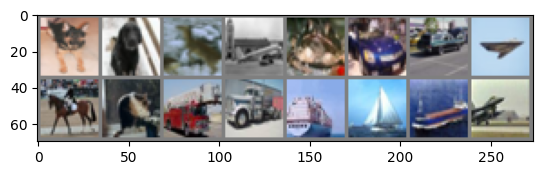

In [29]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# Todo 

Implement two convolutional architectures on this dataset: 
- ResNet with 10 hidden layers
- VGG 16

Try to get state of the art performance. 

In [32]:
#ResNet